# Environment

In [43]:
import dataclasses
import os
from cmath import inf
from collections import namedtuple
from copy import deepcopy
from enum import Enum
from pathlib import Path
from typing import Any, List

import gym
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding
from matplotlib import pyplot as plt

BaseEnvTimestep = namedtuple('BaseEnvTimestep', ['obs', 'reward', 'done', 'info'])


def load_dataset(name, index_name):
    base_dir = os.path.dirname(os.path.abspath('STOCKS_GOOGL.csv'))
    path = os.path.join(base_dir, name + '.csv')
    assert os.path.exists(
        path
    ), "You need to put the stock data under the \'environment/envs/data\' folder.\n \
        if using StocksEnv, you can download Google stocks data at \
        https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/datasets/data/STOCKS_GOOGL.csv"

    df = pd.read_csv(path, parse_dates=True, index_col=index_name)
    return df


class Action(int, Enum):
    DOUBLE_SELL = 0
    SELL = 1
    HOLD = 2
    BUY = 3
    DOUBLE_BUY = 4


class Position(int, Enum):
    SHORT = -1.
    FLAT = 0.
    LONG = 1.


@dataclasses.dataclass
class State:
    history: np.ndarray
    position_history: List[Position]
    tick: float


def transform(position: Position, action: Action) -> Any:
    """
    Overview:
        used by environment.step().
        This func is used to transform the environment's position from
        the input (position, action) pair according to the status machine.
    Arguments:
        - position(Positions) : Long, Short or Flat
        - action(int) : Double_Sell, Sell, Hold, Buy, Double_Buy
    Returns:
        - next_position(Positions) : the position after transformation.
    """
    if action == Action.SELL:
        if position == Position.LONG:
            return Position.FLAT, False

        if position == Position.FLAT:
            return Position.SHORT, True

    if action == Action.BUY:
        if position == Position.SHORT:
            return Position.FLAT, False

        if position == Position.FLAT:
            return Position.LONG, True

    if action == Action.DOUBLE_SELL and (position == Position.LONG or position == Position.FLAT):
        return Position.SHORT, True

    if action == Action.DOUBLE_BUY and (position == Position.SHORT or position == Position.FLAT):
        return Position.LONG, True

    return position, False


class StocksEnv:
    def __init__(self, cfg):
        self._cfg = cfg
        self._env_id = cfg.env_id
        # ======== param to plot =========
        self.cnt = 0

        if 'plot_freq' not in self._cfg:
            self.plot_freq = 10
        else:
            self.plot_freq = self._cfg.plot_freq
        if 'save_path' not in self._cfg:
            self.save_path = 'data/plots/'
        else:
            self.save_path = self._cfg.save_path
        # ================================

        self.train_range = cfg.train_range
        self.test_range = cfg.test_range
        self.window_size = cfg.window_size
        self.prices = None
        self.signal_features = None
        self.feature_dim_len = None
        self.shape = (cfg.window_size, 3)

        # ======== param about episode =========
        self._start_tick = 0
        self._end_tick = 0
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        # ======================================

        self._init_flag = True
        # init the following variables variable at first reset.
        self._action_space = None
        self._observation_space = None
        self._reward_space = None

        self._profit_history = [1.]
        # ====== load Google stocks data =======
        raw_data = load_dataset(self._cfg.stocks_data_filename, 'Date')
        self.raw_prices = raw_data.loc[:, 'Close'].to_numpy()
        EPS = 1e-10
        self.df = deepcopy(raw_data)
        if self.train_range is None or self.test_range is None:
            self.df = self.df.apply(lambda x: (x - x.mean()) / (x.std() + EPS), axis=0)
        else:
            boundary = int(len(self.df) * self.train_range)
            train_data = raw_data[:boundary].copy()
            boundary = int(len(raw_data) * (1 + self.test_range))
            test_data = raw_data[boundary:].copy()

            train_data = train_data.apply(lambda x: (x - x.mean()) / (x.std() + EPS), axis=0)
            test_data = test_data.apply(lambda x: (x - x.mean()) / (x.std() + EPS), axis=0)
            self.df.loc[train_data.index, train_data.columns] = train_data
            self.df.loc[test_data.index, test_data.columns] = test_data
        # ======================================

        # set costs
        self.trade_fee_bid_percent = 0.01  # unit
        self.trade_fee_ask_percent = 0.005  # unit
        # self.trade_fee_bid_percent = 0  # unit
        # self.trade_fee_ask_percent = 0  # unit

    # override
    def _process_data(self, start_idx: int = None) -> Any:
        """
        Overview:
            used by environment.reset(), process the raw data.
        Arguments:
            - start_idx (int): the start tick; if None, then randomly select.
        Returns:
            - prices: the close.
            - signal_features: feature map
            - feature_dim_len: the dimension length of selected feature
        """

        # ====== build feature map ========
        all_feature_name = ['Close', 'Open', 'High', 'Low', 'Adj Close', 'Volume']
        all_feature = {k: self.df.loc[:, k].to_numpy() for k in all_feature_name}
        # add feature "Diff"
        prices = self.df.loc[:, 'Close'].to_numpy()
        diff = np.insert(np.diff(prices), 0, 0)
        all_feature_name.append('Diff')
        all_feature['Diff'] = diff
        # =================================

        # you can select features you want
        # selected_feature_name = ['Close', 'Diff', 'Volume']
        selected_feature_name = ['Close', 'Open', 'High', 'Low', 'Adj Close', 'Volume']
        selected_feature = np.column_stack([all_feature[k] for k in selected_feature_name])
        feature_dim_len = len(selected_feature_name)

        # validate index
        if start_idx is None:
            if self.train_range is None or self.test_range is None:
                self.start_idx = np.random.randint(self.window_size, len(self.df) - self._cfg.eps_length)
            elif self._env_id[-1] == 'e':
                boundary = int(len(self.df) * (1 + self.test_range))
                assert len(
                    self.df) - self._cfg.eps_length > boundary + self.window_size, "parameter test_range is too large!"
                self.start_idx = np.random.randint(boundary + self.window_size, len(self.df) - self._cfg.eps_length)
            else:
                boundary = int(len(self.df) * self.train_range)
                assert boundary - self._cfg.eps_length > self.window_size, "parameter test_range is too small!"
                self.start_idx = np.random.randint(self.window_size, boundary - self._cfg.eps_length)
        else:
            self.start_idx = start_idx

        self._start_tick = self.start_idx
        self._end_tick = self._start_tick + self._cfg.eps_length - 1

        return prices, selected_feature, feature_dim_len

    # override
    def _calculate_reward(self, action: Action) -> float:
        step_reward = 0.
        current_price = (self.raw_prices[self._current_tick])
        last_trade_price = (self.raw_prices[self._last_trade_tick])
        ratio = current_price / last_trade_price
        cost = np.log((1 - self.trade_fee_ask_percent) * (1 - self.trade_fee_bid_percent))

        if action == Action.BUY and self._position == Position.SHORT:
            step_reward = np.log(2 - ratio) + cost

        if action == Action.SELL and self._position == Position.LONG:
            step_reward = np.log(ratio) + cost

        if action == Action.DOUBLE_SELL and self._position == Position.LONG:
            step_reward = np.log(ratio) + cost

        if action == Action.DOUBLE_BUY and self._position == Position.SHORT:
            step_reward = np.log(2 - ratio) + cost

        step_reward = float(step_reward)

        return step_reward

    # override
    def max_possible_profit(self) -> float:
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            if self.raw_prices[current_tick] < self.raw_prices[current_tick - 1]:
                while (current_tick <= self._end_tick
                       and self.raw_prices[current_tick] < self.raw_prices[current_tick - 1]):
                    current_tick += 1

                current_price = self.raw_prices[current_tick - 1]
                last_trade_price = self.raw_prices[last_trade_tick]
                tmp_profit = profit * (2 - (current_price / last_trade_price)) * (1 - self.trade_fee_ask_percent
                                                                                  ) * (1 - self.trade_fee_bid_percent)
                profit = max(profit, tmp_profit)
            else:
                while (current_tick <= self._end_tick
                       and self.raw_prices[current_tick] >= self.raw_prices[current_tick - 1]):
                    current_tick += 1

                current_price = self.raw_prices[current_tick - 1]
                last_trade_price = self.raw_prices[last_trade_tick]
                tmp_profit = profit * (current_price / last_trade_price) * (1 - self.trade_fee_ask_percent
                                                                            ) * (1 - self.trade_fee_bid_percent)
                profit = max(profit, tmp_profit)
            last_trade_tick = current_tick - 1

        return profit

    def seed(self, seed: int, dynamic_seed: bool = True) -> None:
        self._seed = seed
        self._dynamic_seed = dynamic_seed
        np.random.seed(self._seed)
        self.np_random, seed = seeding.np_random(seed)

    def reset(self, start_idx: int = None) -> State:
        self.cnt += 1
        self.prices, self.signal_features, self.feature_dim_len = self._process_data(start_idx)
        if self._init_flag:
            self.shape = (self.window_size, self.feature_dim_len)
            self._action_space = spaces.Discrete(len(Action))
            self._observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64)
            self._reward_space = gym.spaces.Box(-inf, inf, shape=(1,), dtype=np.float32)
            self._init_flag = False
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Position.FLAT
        self._position_history = [self._position]
        self._profit_history = [1.]
        self._total_reward = 0.

        return self._get_observation()

    def random_action(self) -> Any:
        return np.array([self.action_space.sample()])

    def position_history(self, n) -> List[float]:
        # Returns the n most recent positions
        if n < len(self._position) - 1:
            return self._position
        else:
            return self._position[-n:]

    def step(self, action: Action) -> BaseEnvTimestep:
        self._done = False
        self._current_tick += 1

        if self._current_tick >= self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._position, trade = transform(self._position, action)

        if trade:
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        self._profit_history.append(float(np.exp(self._total_reward)))
        observation = self._get_observation()
        info = dict(
            total_reward=self._total_reward,
            position=self._position.value,
        )

        if self._done:
            if self._env_id[-1] == 'e' and self.cnt % self.plot_freq == 0:
                self.render()
            info['max_possible_profit'] = np.log(self.max_possible_profit())
            info['final_eval_reward'] = self._total_reward

        return BaseEnvTimestep(observation, step_reward, self._done, info)

    def _get_observation(self) -> State:
        obs = np.array(self.signal_features[(self._current_tick - self.window_size + 1):
                                            self._current_tick + 1]).astype(np.float32)

        tick = (self._current_tick - self._last_trade_tick) / self._cfg.eps_length

        return State(history=obs,
                     position_history=self._position_history[-min(len(self._position_history), self.window_size):],
                     tick=tick)

    def render_profit(self, save=False):
        plt.clf()
        plt.xlabel('trading days')
        plt.ylabel('profit')
        plt.plot(self._profit_history)
        if save:
            plt.savefig(self.save_path + str(self._env_id) + "-profit.png")
        else:
            plt.show()

    def render_price(self, save=False):
        plt.clf()
        plt.xlabel('trading days')
        plt.ylabel('close price')
        window_ticks = np.arange(len(self._position_history))
        eps_price = self.raw_prices[self._start_tick:self._end_tick + 1]
        plt.plot(eps_price)

        short_ticks = []
        long_ticks = []
        flat_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Position.SHORT:
                short_ticks.append(tick)
            elif self._position_history[i] == Position.LONG:
                long_ticks.append(tick)
            else:
                flat_ticks.append(tick)

        plt.plot(long_ticks, eps_price[long_ticks], 'g^', markersize=3, label="Long")
        plt.plot(flat_ticks, eps_price[flat_ticks], 'bo', markersize=3, label="Flat")
        plt.plot(short_ticks, eps_price[short_ticks], 'rv', markersize=3, label="Short")
        plt.legend(loc='upper left', bbox_to_anchor=(0.05, 0.95))
        if save:
            plt.savefig(self.save_path + str(self._env_id) + '-price.png')
        else:
            plt.show()

    def final_profit(self) -> float:
        return self._profit_history[-1]

    def render(self, save=True) -> None:
        self.render_profit(save)
        self.render_price(save)

    def render_together(self, save=True, filename: str = None) -> None:
        fig, axs = plt.subplots(2)

        axs[0].set_xlabel('trading days')
        axs[0].set_ylabel('close price')
        window_ticks = np.arange(len(self._position_history))
        eps_price = self.raw_prices[self._start_tick:self._end_tick + 1]
        axs[0].plot(eps_price)

        short_ticks = []
        long_ticks = []
        flat_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Position.SHORT:
                short_ticks.append(tick)
            elif self._position_history[i] == Position.LONG:
                long_ticks.append(tick)
            else:
                flat_ticks.append(tick)

        axs[0].plot(long_ticks, eps_price[long_ticks], 'g^', markersize=3, label="Long")
        axs[0].plot(flat_ticks, eps_price[flat_ticks], 'bo', markersize=3, label="Flat")
        axs[0].plot(short_ticks, eps_price[short_ticks], 'rv', markersize=3, label="Short")
        axs[0].legend(loc='upper left', bbox_to_anchor=(0.05, 0.95))

        # profit history below
        axs[1].set_xlabel('trading days')
        axs[1].set_ylabel('profit')
        axs[1].plot(self._profit_history)

        if not filename:
            filename = self.save_path + str(self._env_id) + '-price-profit.png'

        Path(filename[:filename.rindex('/')]).mkdir(parents=True, exist_ok=True)
        plt.savefig(filename)

    def close(self):
        plt.close()

    @property
    def observation_space(self) -> gym.spaces.Space:
        return self._observation_space

    @property
    def action_space(self) -> gym.spaces.Space:
        return self._action_space

    @property
    def reward_space(self) -> gym.spaces.Space:
        return self._reward_space

    def __repr__(self) -> str:
        return "DI-engine Stocks Trading Env"



# Utility Functions

In [44]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # plot results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

In [45]:
import time
from dateutil import tz
from typing import Optional
import dill as pickle

import datetime


@dataclasses.dataclass
class ExperimentResult:
    config: Any
    final_env: Optional[StocksEnv]
    profits: List[float]
    returns: Optional[List[float]]
    loss: Optional[List[float]]
    max_possible_profits: Optional[List[float]]
    buy_and_hold_profits: Optional[List[float]]
    algorithm: str
    timestamp: str = dataclasses.field(init=False)

    def __post_init__(self):
        self.timestamp = datetime.datetime.utcfromtimestamp(time.time()).replace(tzinfo=tz.gettz('UTC')).astimezone(
            tz=tz.gettz('America/Boston')).strftime('%Y-%m-%d--%H-%M-%S')

    def to_file(self):
        with open(self.pickle_filename(), 'wb') as f:
            pickle.dump(self, f)
            return self.pickle_filename()

    def pickle_filename(self) -> str:
        return f'data/{self.algorithm}_{self.timestamp}.pickle'

    def name(self) -> str:
        return f'{self.algorithm}_{self.timestamp}'

    @staticmethod
    def from_file(path: str) -> 'ExperimentResult':
        with open(path, 'rb') as handle:
            return pickle.load(handle)

# DQN Agent Definition

In [61]:
from torch.nn import Conv2d, Flatten, LazyLinear, MaxPool2d, ReLU
import torch
import tqdm
from torch import nn


# customized weight initialization
def customized_weights_init(m):
    # compute the gain
    gain = nn.init.calculate_gain('relu')
    # init the convolutional layer
    if isinstance(m, nn.Conv2d):
        # init the params using uniform
        nn.init.xavier_uniform_(m.weight, gain=gain)
        nn.init.constant_(m.bias, 0)
    # init the linear layer
    if isinstance(m, nn.Linear):
        # init the params using uniform
        nn.init.xavier_uniform_(m.weight, gain=gain)
        nn.init.constant_(m.bias, 0)


class DeepQNet(nn.Module):
    def __init__(self, input_dim, num_hidden_layer, dim_hidden_layer, output_dim):
        super(DeepQNet, self).__init__()

        """CODE HERE: construct your Deep neural network
        """

        self.layers = nn.ModuleList()
        # self.input_size = input_dim
        #
        # self.layers.append(nn.Linear(in_features=input_dim, out_features=dim_hidden_layer))
        # self.layers.append(nn.ReLU())
        # for i in range(num_hidden_layer):
        #     self.layers.append(nn.Linear(in_features=dim_hidden_layer, out_features=dim_hidden_layer))
        #     self.layers.append(nn.ReLU())
        # self.layers.append(nn.Linear(in_features=dim_hidden_layer, out_features=output_dim))

        self.layers.append(Conv2d(in_channels=1, out_channels=1, kernel_size=(2, 1)))
        self.layers.append(ReLU())
        self.layers.append(MaxPool2d(kernel_size=(4, 1), stride=(1, 1)))

        self.layers.append(Conv2d(in_channels=1, out_channels=1, kernel_size=(4, 1)))
        self.layers.append(ReLU())
        self.layers.append(MaxPool2d(kernel_size=(4, 1), stride=(2, 1)))

        self.layers.append(Conv2d(in_channels=1, out_channels=1, kernel_size=(8, 1)))
        self.layers.append(ReLU())
        self.layers.append(MaxPool2d(kernel_size=(4, 1), stride=(2, 1)))

        self.layers.append(Conv2d(in_channels=1, out_channels=1, kernel_size=(16, 1)))
        self.layers.append(ReLU())
        self.layers.append(MaxPool2d(kernel_size=(8, 1), stride=(2, 1)))

        self.layers.append(Flatten())
        self.layers.append(LazyLinear(out_features=64))
        self.layers.append(ReLU())

        self.layers.append(LazyLinear(out_features=5))

    def forward(self, x):
        """CODE HERE: implement your forward propagation
        """
        for idx, layer in enumerate(self.layers):
            # print(f'On layer {idx}({layer.__class__}) with input shape {x.size()}')
            x = layer(x)
        return x


class ReplayBuffer(object):
    """ Implement the Replay Buffer as a class, which contains:
            - self._data_buffer (list): a list variable to store all transition tuples.
            - add: a function to add new transition tuple into the buffer
            - sample_batch: a function to sample a batch training data from the Replay Buffer
    """

    def __init__(self, buffer_size):
        """Args:
               buffer_size (int): size of the replay buffer
        """
        # total size of the replay buffer
        self.total_size = buffer_size

        # create a list to store the transitions
        self._data_buffer = []
        self._next_idx = 0

    def __len__(self):
        return len(self._data_buffer)

    def add(self, obs, act, reward, next_obs, done):
        # create a tuple
        trans = (obs, act, reward, next_obs, done)

        # interesting implementation
        if self._next_idx >= len(self._data_buffer):
            self._data_buffer.append(trans)
        else:
            self._data_buffer[self._next_idx] = trans

        # increase the index
        self._next_idx = (self._next_idx + 1) % self.total_size

    def _encode_sample(self, indices):
        """ Function to fetch the state, action, reward, next state, and done arrays.

            Args:
                indices (list): list contains the index of all sampled transition tuples.
        """
        # lists for transitions
        obs_list, actions_list, rewards_list, next_obs_list, dones_list = [], [], [], [], []

        # collect the data
        for idx in indices:
            # get the single transition
            data = self._data_buffer[idx]
            obs, act, reward, next_obs, d = data
            # store to the list
            obs_list.append(np.array(obs, copy=False))
            actions_list.append(np.array(act, copy=False))
            rewards_list.append(np.array(reward, copy=False))
            next_obs_list.append(np.array(next_obs, copy=False))
            dones_list.append(np.array(d, copy=False))
        # return the sampled batch data as numpy arrays
        return np.array(obs_list), np.array(actions_list), np.array(rewards_list), np.array(next_obs_list), np.array(
            dones_list)

    def sample_batch(self, batch_size):
        """ Args:
                batch_size (int): size of the sampled batch data.
        """
        # sample indices with replaced
        indices = [np.random.randint(0, len(self._data_buffer)) for _ in range(batch_size)]
        return self._encode_sample(indices)


class LinearSchedule(object):
    """ This schedule returns the value linearly"""

    def __init__(self, start_value, end_value, duration):
        # start value
        self._start_value = start_value
        # end value
        self._end_value = end_value
        # time steps that value changes from the start value to the end value
        self._duration = duration
        # difference between the start value and the end value
        self._schedule_amount = end_value - start_value

    def get_value(self, time):
        # logic: if time > duration, use the end value, else use the scheduled value
        """ CODE HERE: return the epsilon for each time step within the duration.
        """
        if time > self._duration:
            return self._end_value
        else:
            return self._start_value + (time / self._duration * (self._end_value - self._start_value))


class EpsilonDownUpDown:
    # It looks like this
    """
    e1 --- \
           .\  * -------- e3
           . \ |\
           .  \| \
    e2 ----+-- *  \ ----- e4
           .   .   .
           .   .   .
           0   t1  t2

    """

    def __init__(self, e1, e2, e3, e4, t1, t2):
        self.t1 = t1
        self.t2 = t2

        self.schedules = [
            LinearSchedule(start_value=e1, end_value=e2, duration=t1),
            LinearSchedule(start_value=e3, end_value=e4, duration=t2 - t1)
        ]

    def get_value(self, t):
        if t < self.t1:
            return self.schedules[0].get_value(t)
        else:
            return self.schedules[1].get_value(t - self.t1)


class DQNAgent(object):
    # initialize the agent
    def __init__(self,
                 params,
                 ):
        # save the parameters
        self.params = params

        # environment parameters
        self.action_dim = params['action_dim']
        self.obs_dim = params['observation_dim']

        # executable actions
        self.action_space = params['action_space']

        # create behavior policy network
        self.behavior_policy_net = DeepQNet(input_dim=params['observation_dim'],
                                            num_hidden_layer=params['hidden_layer_num'],
                                            dim_hidden_layer=params['hidden_layer_dim'],
                                            output_dim=params['action_dim'])
        # create target network
        self.target_policy_net = DeepQNet(input_dim=params['observation_dim'],
                                          num_hidden_layer=params['hidden_layer_num'],
                                          dim_hidden_layer=params['hidden_layer_dim'],
                                          output_dim=params['action_dim'])

        # initialize target network with behavior network
        self.behavior_policy_net.apply(customized_weights_init)  # TODO: should custom initialization?
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())

        # send the agent to a specific device: cpu or gpu
        # self.device = torch.device("cpu")
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.behavior_policy_net.to(self.device)
        self.target_policy_net.to(self.device)

        # optimizer
        self.optimizer = torch.optim.Adam(self.behavior_policy_net.parameters(), lr=params['learning_rate'])

    # get action
    def get_action(self, obs, eps):
        if np.random.random() < eps:  # with probability eps, the agent selects a random action
            action = self.action_space.sample()
        else:  # with probability 1 - eps, the agent selects a greedy policy
            obs = self._arr_to_tensor(obs)
            # obs = self._arr_to_tensor(obs).view(1, -1)
            with torch.no_grad():
                q_values = self.behavior_policy_net(obs)
                action = q_values.max(dim=1)[1].item()
        return action

    # update behavior policy
    def update_behavior_policy(self, batch_data, timestep):
        # convert batch data to tensor and put them on device
        batch_data_tensor = self._batch_to_tensor(batch_data)

        # get the transition data
        obs_tensor = batch_data_tensor['obs']
        actions_tensor = batch_data_tensor['action']
        next_obs_tensor = batch_data_tensor['next_obs']
        rewards_tensor = batch_data_tensor['reward']
        dones_tensor = batch_data_tensor['done']

        """CODE HERE:
                Compute the predicted Q values using the behavior policy network
        """
        q_estimate = self.behavior_policy_net(obs_tensor).gather(dim=1, index=actions_tensor).flatten()
        with torch.no_grad():
            q_max = torch.max(self.target_policy_net(next_obs_tensor), dim=1).values

            td_target = rewards_tensor.flatten() + self.params['gamma'] * q_max
            done_idxs = (dones_tensor == 1).nonzero(as_tuple=True)[0]
            td_target[done_idxs] = rewards_tensor[done_idxs, 0]

        loss_accumulation_steps = 200

        # compute the loss
        td_loss = torch.nn.MSELoss()(q_estimate, td_target)
        td_loss.backward()

        # minimize the loss
        self.optimizer.step()
        self.behavior_policy_net.zero_grad()

        return td_loss.item()

    # update update target policy
    def update_target_policy(self):
        # hard update
        """CODE HERE:
                Copy the behavior policy network to the target network
        """
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())

    # load trained model
    def load_model(self, model_file):
        # load the trained model
        self.behavior_policy_net.load_state_dict(torch.load(model_file, map_location=self.device))
        self.behavior_policy_net.eval()

    # auxiliary functions
    def _arr_to_tensor(self, arr):
        arr = np.array(arr).reshape((-1, 1, arr.shape[0], arr.shape[1]))
        arr_tensor = torch.from_numpy(arr).float().to(self.device)
        return arr_tensor

    def _batch_to_tensor(self, batch_data):
        # store the tensor
        batch_data_tensor = {'obs': [], 'action': [], 'reward': [], 'next_obs': [], 'done': []}
        # get the numpy arrays
        obs_arr, action_arr, reward_arr, next_obs_arr, done_arr = batch_data
        # convert to tensors
        batch_data_tensor['obs'] = torch.as_tensor(obs_arr, dtype=torch.float32, device=self.device).reshape(
            (-1, 1, obs_arr.shape[1], obs_arr.shape[2]))  # for CNN
        batch_data_tensor['action'] = torch.as_tensor(action_arr, device=self.device).long().view(-1, 1)
        batch_data_tensor['reward'] = torch.as_tensor(reward_arr, dtype=torch.float32, device=self.device).view(-1, 1)
        batch_data_tensor['next_obs'] = torch.as_tensor(next_obs_arr, dtype=torch.float32, device=self.device).reshape(
            (-1, 1, obs_arr.shape[1], obs_arr.shape[2]))
        batch_data_tensor['done'] = torch.as_tensor(done_arr, dtype=torch.float32, device=self.device).view(-1, 1)

        return batch_data_tensor


def train_dqn_agent(env, params):
    # create the DQN agent
    my_agent = DQNAgent(params)

    # create the epsilon-greedy schedule
    # my_schedule = LinearSchedule(start_value=params['epsilon_start_value'],
    #                              end_value=params['epsilon_end_value'],
    #                              duration=params['epsilon_duration'])

    my_schedule = EpsilonDownUpDown(e1=params['epsilon_start_value'],
                                    e2=params['epsilon_end_value'],
                                    e3=params['epsilon_start_value'] * 0.75,
                                    e4=0,
                                    t1=params['epsilon_duration'] * 0.66,
                                    t2=params['epsilon_duration'])

    # create the replay buffer
    replay_buffer = ReplayBuffer(params['replay_buffer_size'])

    # training variables
    episode_t = 0
    rewards = []
    train_returns = []
    train_loss = []
    profits = []

    # reset the environment
    obs = env.reset()

    num_episodes = params['total_training_time_step'] // params['max_time_step_per_episode']

    # start training
    pbar = tqdm.trange(params['total_training_time_step'])
    last_best_return = np.negative(np.inf)
    for t in pbar:
        # scheduled epsilon at time step t
        eps_t = my_schedule.get_value(t)
        # get one epsilon-greedy action
        action = my_agent.get_action(obs, eps_t)

        # step in the environment
        next_obs, reward, done, _ = env.step(action)

        # add to the buffer
        replay_buffer.add(obs, action, reward, next_obs, done)
        rewards.append(reward)

        # check termination
        if done or episode_t == params['max_time_step_per_episode'] - 1:
            # compute the return
            G = 0
            for r in reversed(rewards):
                G = r + params['gamma'] * G

            # if G > last_best_return:
            #     torch.save(my_agent.behavior_policy_net.state_dict(), f"./{params['model_name']}")

            # store the return
            train_returns.append(G)
            episode_idx = len(train_returns)

            # print the information
            pbar.set_description(
                f"Ep={episode_idx} | "
                f"G={np.mean(train_returns[-10:]) if train_returns else 0:.2f} | "
                f"Eps={eps_t:.5f}"
            )

            # plot the last x episodes
            # if episode_idx == 1 or episode_idx > num_episodes - params['final_policy_num_plots']:
            #     env.render_together(save=True, filename=f'data/plots/dqn2_{params["name"]}/episode_{episode_idx}')

            # reset the environment
            episode_t, rewards = 0, []
            profits.append(env.final_profit())
            env.close()
            obs = env.reset()
        else:
            # increment
            obs = next_obs
            episode_t += 1

        if t > params['start_training_step']:
            # update the behavior model
            if not np.mod(t, params['freq_update_behavior_policy']):
                """ CODE HERE:
                    Update the behavior policy network
                """
                train_loss.append(my_agent.update_behavior_policy(replay_buffer.sample_batch(params['batch_size']), t))

            # update the target model
            if not np.mod(t, params['freq_update_target_policy']):
                """ CODE HERE:
                    Update the target policy network
                """
                my_agent.update_target_policy()

    # save the results
    return train_returns, train_loss, profits

In [62]:
from easydict import EasyDict
import random


class StocksEnvWithFeatureVectors(StocksEnv):

    def _get_observation(self) -> np.ndarray:
        observation = super()._get_observation()
        position_history = np.zeros(shape=(observation.history.shape[0], 1))
        position_history[-len(observation.position_history):, 0] = observation.position_history

        # gives a warning because it's not a state but shut the up
        # align the position history with where the stock was at that point
        return np.hstack([observation.history, position_history])


def main(name: str):
    np.random.seed(1234)
    random.seed(1234)
    torch.manual_seed(1234)

    env = StocksEnvWithFeatureVectors(EasyDict({
        "env_id": 'stocks-dqn', "eps_length": 200,
        "window_size": 200, "train_range": None, "test_range": None,
        "stocks_data_filename": 'STOCKS_GOOGL'
    }))

    initial_obs = env.reset()

    # create training parameters
    train_parameters = {
        'observation_dim': initial_obs.shape,
        'action_dim': 5,
        'action_space': env.action_space,
        'hidden_layer_num': 16,
        'hidden_layer_dim': 32,
        'gamma': 0.99,

        'max_time_step_per_episode': 200,

        'total_training_time_step': 500_000,

        'epsilon_start_value': 1.0,
        'epsilon_end_value': 0.0,
        'epsilon_duration': 250_000,

        'replay_buffer_size': 50000,
        'start_training_step': 2000,
        'freq_update_behavior_policy': 4,
        'freq_update_target_policy': 2000,

        'batch_size': 32,
        'learning_rate': 1e-3,

        'final_policy_num_plots': 20,

        'model_name': "stocks_google.pt",
        'name': name
    }

    # create experiment
    train_returns, train_loss, train_profits = train_dqn_agent(env, train_parameters)
    plot_curves([np.array([train_returns])], ['dqn'], ['r'], 'discounted return', 'DQN2')
    plt.savefig(f'dqn2_returns_{name}')
    plt.clf()
    plot_curves([np.array([train_loss])], ['dqn'], ['r'], 'training loss', 'DQN2')
    plt.savefig(f'dqn2_loss_{name}')
    plt.clf()
    plot_curves([np.array([train_profits])], ['dqn'], ['r'], 'profit', 'DQN2')
    plt.savefig(f'dqn2_profits_{name}')

    ExperimentResult(
        config=train_parameters,
        final_env=None,
        profits=train_profits,
        returns=train_returns,
        loss=train_loss,
        max_possible_profits=None,
        buy_and_hold_profits=None,
        algorithm='dqn2_name'
    ).to_file()

/Users/marc/opt/anaconda3/envs/rl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Ep=2512 | G=-0.02 | Eps=0.00000: 100%|██████████| 500000/500000 [39:03<00:00, 213.39it/s] 


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

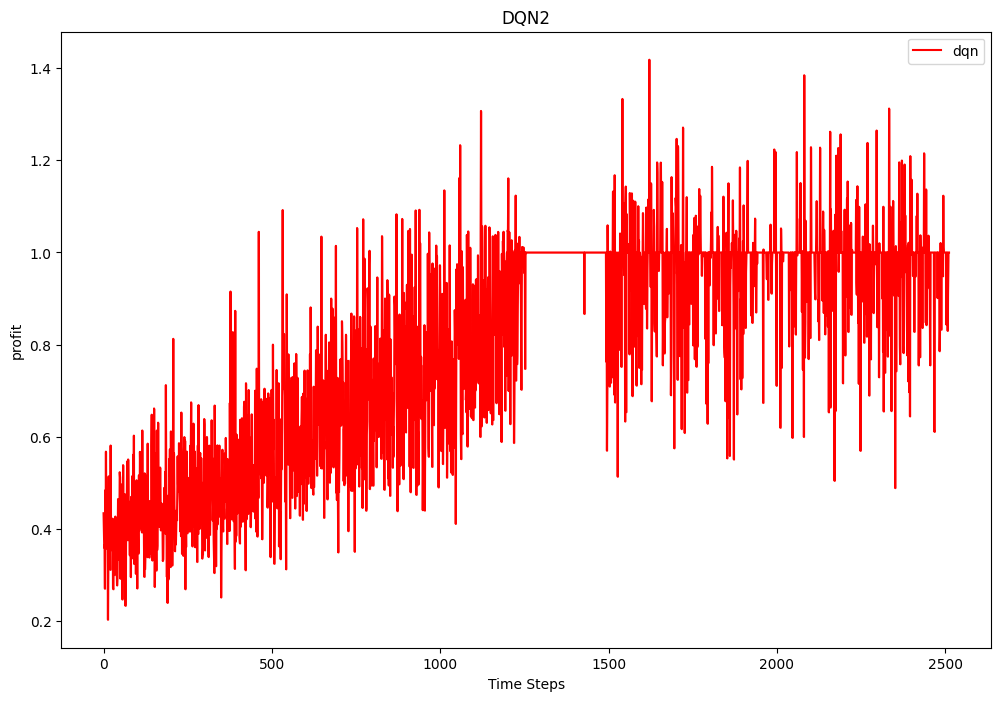

In [63]:
main('altogether')